# Transformer for forecast without features

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from xgboost import XGBRegressor
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"
device = torch.device(dev)

## load data

In [2]:
url = '../data/beijing.csv'
data = pd.read_csv(url, sep=',', index_col='time')
data = data[['load']]

## normalization

In [3]:
def normalization(data):
    """
    data: original data with load
    return: normalized data, scaler of load
    """
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(data)
    scaler_y = MinMaxScaler()
    scaler_y.fit_transform(data[[data.columns[-1]]])
    return normalized_data, scaler, scaler_y

## build supervised dataset

In [4]:
def series_to_supervise(data, seq_len, target_len):
    """
    convert series data to supervised data
    :param data: original data
    :param seq_len: length of input sequence
    :param target_len: length of ouput sequence
    :return: return two ndarrays-- input and output in format suitable to feed to LSTM
    """
    dim_0 = data.shape[0] - seq_len - target_len + 1
    dim_1 = data.shape[1]
    x = np.zeros((dim_0, seq_len + target_len, dim_1))
    y = np.zeros((dim_0, target_len))
    for i in range(dim_0):
        x[i] = data[i:i + seq_len + target_len]
        y[i] = data[i + seq_len:i + seq_len + target_len, -1]
    print("supervised data: shape of x: {}, shape of y: {}".format(
        x.shape, y.shape))
    return x, y

## 5-folds TimeSeriesSplit

In [5]:
def time_series_split(X, Y, n_split=5):
    """
    X: features, size * seq_len * feature_num
    Y: labels, size * target_len
    return: list of train_x, test_x, train_y, test_y
    """
    tscv = TimeSeriesSplit(n_splits=n_split)
    train_x_list = list()
    valid_x_list = list()
    train_y_list = list()
    valid_y_list = list()
    for train_index, valid_index in tscv.split(X):
        train_x_list.append(X[train_index])
        train_y_list.append(Y[train_index])
        valid_x_list.append(X[valid_index])
        valid_y_list.append(Y[valid_index])
    return train_x_list, train_y_list, valid_x_list, valid_y_list

## Transform model

### PositionalEncoding

In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() *
            (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

### generate mask

In [7]:
def generate_square_subsequent_mask(sz):
    """
    Generate a square mask for the sequence. The masked positions are filled with float(‘-inf’). Unmasked positions are filled with float(0.0).
    """
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(
        mask == 1, float(0.0))
    return mask.to(device)

### transformer

In [8]:
class Transformer(nn.Module):
    def __init__(self, input_size, d_model, nhead, n_layers, drop_prob):
        super(Transformer, self).__init__()
        self.embedding = nn.Sequential(nn.Linear(input_size, d_model),
                                       nn.ReLU())
        self.pe = PositionalEncoding(d_model=d_model)
        self.transformer = nn.Transformer(d_model=d_model,
                                          nhead=nhead,
                                          num_encoder_layers=n_layers,
                                          num_decoder_layers=n_layers,
                                          dim_feedforward=4 * d_model,
                                          dropout=drop_prob,
                                          batch_first=True)
        self.out = nn.Linear(d_model, 1)

    def forward(self, src, tgt, is_tgt_mask=True):
        src = self.embedding(src)
        tgt = self.embedding(tgt)
        src = self.pe(src)
        tgt = self.pe(tgt)
        if is_tgt_mask:
            tgt_mask = generate_square_subsequent_mask(tgt.shape[1])
            output = self.transformer(src, tgt, tgt_mask=tgt_mask)
        else:
            output = self.transformer(src, tgt)
        output = self.out(output)
        return output

## model training for HPO

In [22]:
def train_model_hpo(train_x_list, train_y_list, valid_x_list, valid_y_list,
                    input_size, seq_len, target_len, mse_thresh, d_model,
                    nhead, n_layers, number_epoch, batch_size, lr, drop_prob):
    valid_loss_list = []
    for num in range(len(train_x_list)):
        while (1):
            model = Transformer(input_size, d_model, nhead, n_layers,
                                drop_prob)
            model = model.to(device)
            criterion = nn.MSELoss()
            optimizer = torch.optim.Adam(model.parameters(),
                                         lr=lr,
                                         betas=(0.9, 0.98),
                                         eps=1e-9)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                        step_size=1,
                                                        gamma=0.98)
            valid_loss_min = np.Inf
            print('train dataset {}'.format(num))
            train_x = train_x_list[num]
            train_y = train_y_list[num]
            valid_x = valid_x_list[num]
            valid_y = valid_y_list[num]
            train_dataset = TensorDataset(torch.FloatTensor(train_x),
                                          torch.FloatTensor(train_y))
            valid_dataset = TensorDataset(torch.FloatTensor(valid_x),
                                          torch.FloatTensor(valid_y))

            train_loader = DataLoader(dataset=train_dataset,
                                      batch_size=batch_size,
                                      shuffle=True,
                                      drop_last=True)
            valid_loader = DataLoader(dataset=valid_dataset,
                                      batch_size=batch_size,
                                      shuffle=True,
                                      drop_last=True)
            train_losses = list()

            num_without_imp = 0

            #train
            for epoch in range(1, number_epoch + 1):
                loop = tqdm(enumerate(train_loader),
                            total=len(train_loader),
                            leave=True)
                for i, (inputs, labels) in loop:
                    model.train()
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    optimizer.zero_grad()
                    # train
                    # pdb.set_trace()
                    input_tensor = inputs[:, :seq_len, :]
                    target_tensor = inputs[:, seq_len - 1:seq_len +
                                           target_len - 1, :]
                    outputs = model(input_tensor, target_tensor).squeeze()
                    loss = criterion(outputs, labels)
                    train_losses.append(loss.item)
                    loss.backward()
                    optimizer.step()

                    # eval
                    if i % 5 == 0:
                        num_without_imp = num_without_imp + 1
                        valid_losses = list()
                        model.eval()
                        for inp, lab in valid_loader:
                            inp = inp.to(device)
                            lab = lab.to(device)
                            input_tensor = inp[:, 0:seq_len, :]
                            target_tensor = inp[:, seq_len:, :-1]
                            decoder_input = input_tensor[:, -1, :].unsqueeze(1)
                            for t in range(target_len):
                                decoder_output = model(input_tensor,
                                                       decoder_input,
                                                       is_tgt_mask=False)
                                decoder_input_add = torch.cat(
                                    (target_tensor[:, :t + 1, :],
                                     decoder_output.detach()), 2)
                                decoder_input = torch.cat(
                                    (input_tensor[:, -1, :].unsqueeze(1),
                                     decoder_input_add), 1)
                            valid_loss = criterion(decoder_output.squeeze(),
                                                   lab)
                            valid_losses.append(valid_loss.item())
                        model.train()
                        loop.set_description("Epoch: {}/{}...".format(
                            epoch, number_epoch))
                        loop.set_postfix(train_loss=loss.item(),
                                         valid_loss=np.mean(valid_losses))
                        if np.mean(valid_losses) < valid_loss_min:
                            num_without_imp = 0
                            valid_loss_min = np.mean(valid_losses)
                scheduler.step()
                if num_without_imp > 50:
                    break
            if valid_loss_min < mse_thresh:
                valid_loss_list.append(valid_loss_min)
                break
    return np.mean(valid_loss_list)

## hyper-parameters config

In [10]:
seq_len = 72
target_len = 24
mse_thresh = 0.05


def model_config():
    batch_sizes = [512, 256]
    lrs = [0.01, 0.05, 0.1]
    number_epochs = [40]
    d_models = [16, 32, 64]
    n_layers = [1, 2, 3]
    drop_prob = [0.2, 0.4, 0.5]
    nhead = [2, 4, 8]
    configs = list()
    for i in batch_sizes:
        for j in lrs:
            for k in number_epochs:
                for l in d_models:
                    for m in n_layers:
                        for n in drop_prob:
                            for o in nhead:
                                configs.append({
                                    'batch_size': i,
                                    'lr': j,
                                    'number_epoch': k,
                                    'd_model': l,
                                    'n_layers': m,
                                    'drop_prob': n,
                                    'nhead': o
                                })
    return configs

## random search for HPO

In [11]:
def run_model_hpo(seq_len=seq_len,
                  target_len=target_len,
                  mse_thresh=mse_thresh):
    train_data = data[:int(0.8 * len(data))]
    train_data, _, _ = normalization(train_data)
    train_x, train_y = series_to_supervise(train_data, seq_len, target_len)
    train_x_list, train_y_list, valid_x_list, valid_y_list = time_series_split(
        train_x, train_y)
    #         with enough data
    #     train_x_list = train_x_list[-1:]
    #     train_y_list = train_y_list[-1:]
    #     valid_x_list = valid_x_list[-1:]
    #     valid_y_list = valid_y_list[-1:]

    configs = model_config()
    records = []
    input_size = train_x.shape[2]
    for i in range(10):
        config = random.choice(configs)
        configs.remove(config)
        batch_size = config['batch_size']
        lr = config['lr']
        number_epoch = config['number_epoch']
        d_model = config['d_model']
        n_layers = config['n_layers']
        drop_prob = config['drop_prob']
        nhead = config['nhead']
        print(
            "model config: batch_size-{}, lr-{}, number_epoch-{}, d_model-{}, n_layers-{},drop_prob-{},nhead-{}"
            .format(batch_size, lr, number_epoch, d_model, n_layers, drop_prob,
                    nhead))
        valid_loss = train_model_hpo(train_x_list, train_y_list, valid_x_list,
                                     valid_y_list, input_size, seq_len,
                                     target_len, mse_thresh, d_model, nhead,
                                     n_layers, number_epoch, batch_size, lr,
                                     drop_prob)
        records.append({
            'batch_size': batch_size,
            'lr': lr,
            'number_epoch': number_epoch,
            'd_model': d_model,
            'n_layers': n_layers,
            'drop_prob': drop_prob,            
            'nhead': nhead,
            'valid_loss': valid_loss,
        })
    return records

## run random search

In [12]:
records = run_model_hpo()

supervised data: shape of x: (25232, 96, 16), shape of y: (25232, 24)
model config: batch_size-256, lr-0.01, number_epoch-40, d_model-256, n_layers-3,drop_prob-0.4,nhead-2
train dataset 0


Epoch: 23/40...: 100%|██████████| 16/16 [00:31<00:00,  1.95s/it, train_loss=0.017, valid_loss=0.0324] 


train dataset 1


Epoch: 10/40...: 100%|██████████| 32/32 [01:09<00:00,  2.19s/it, train_loss=0.0276, valid_loss=0.0305]


train dataset 2


Epoch: 14/40...: 100%|██████████| 49/49 [01:34<00:00,  1.93s/it, train_loss=0.0262, valid_loss=0.0385]


train dataset 3


Epoch: 9/40...: 100%|██████████| 65/65 [01:49<00:00,  1.69s/it, train_loss=0.0286, valid_loss=0.0353]


train dataset 4


Epoch: 4/40...: 100%|██████████| 82/82 [02:30<00:00,  1.84s/it, train_loss=0.033, valid_loss=0.038]  


model config: batch_size-512, lr-0.05, number_epoch-40, d_model-128, n_layers-2,drop_prob-0.2,nhead-8
train dataset 0


Epoch: 34/40...: 100%|██████████| 8/8 [00:08<00:00,  1.07s/it, train_loss=0.0185, valid_loss=0.0326]


train dataset 1


Epoch: 17/40...: 100%|██████████| 16/16 [00:15<00:00,  1.04it/s, train_loss=0.0268, valid_loss=0.0305]


train dataset 2


Epoch: 12/40...: 100%|██████████| 24/24 [00:20<00:00,  1.19it/s, train_loss=0.0285, valid_loss=0.0716]


train dataset 3


Epoch: 18/40...: 100%|██████████| 32/32 [00:33<00:00,  1.06s/it, train_loss=0.0307, valid_loss=0.0347]


train dataset 4


Epoch: 18/40...: 100%|██████████| 41/41 [00:37<00:00,  1.09it/s, train_loss=0.0308, valid_loss=0.0346]


model config: batch_size-256, lr-0.05, number_epoch-40, d_model-128, n_layers-2,drop_prob-0.2,nhead-2
train dataset 0


Epoch: 15/40...: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, train_loss=0.0171, valid_loss=0.0526]


train dataset 1


Epoch: 16/40...: 100%|██████████| 32/32 [00:24<00:00,  1.29it/s, train_loss=0.0266, valid_loss=0.0278]


train dataset 2


Epoch: 11/40...: 100%|██████████| 49/49 [00:34<00:00,  1.42it/s, train_loss=0.0304, valid_loss=0.0393]


train dataset 3


Epoch: 9/40...: 100%|██████████| 65/65 [00:47<00:00,  1.38it/s, train_loss=0.0291, valid_loss=0.0347]


train dataset 4


Epoch: 7/40...: 100%|██████████| 82/82 [00:58<00:00,  1.41it/s, train_loss=0.0321, valid_loss=0.0345]


model config: batch_size-512, lr-0.1, number_epoch-40, d_model-64, n_layers-2,drop_prob-0.5,nhead-8
train dataset 0


Epoch: 31/40...: 100%|██████████| 8/8 [00:05<00:00,  1.35it/s, train_loss=0.0173, valid_loss=0.0327]


train dataset 1


Epoch: 15/40...: 100%|██████████| 16/16 [00:11<00:00,  1.37it/s, train_loss=0.0279, valid_loss=0.0325]


train dataset 2


Epoch: 17/40...: 100%|██████████| 24/24 [00:15<00:00,  1.58it/s, train_loss=0.0261, valid_loss=0.0394]


train dataset 3


Epoch: 9/40...: 100%|██████████| 32/32 [00:19<00:00,  1.65it/s, train_loss=0.0315, valid_loss=0.0356]


train dataset 4


Epoch: 15/40...: 100%|██████████| 41/41 [00:26<00:00,  1.52it/s, train_loss=0.0303, valid_loss=0.0355]


model config: batch_size-256, lr-0.05, number_epoch-40, d_model-64, n_layers-2,drop_prob-0.5,nhead-8
train dataset 0


Epoch: 14/40...: 100%|██████████| 16/16 [00:12<00:00,  1.27it/s, train_loss=0.0183, valid_loss=0.0421]


train dataset 1


Epoch: 8/40...:  97%|█████████▋| 31/32 [00:20<00:00,  1.41it/s, train_loss=0.0265, valid_loss=0.0289]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 19/40...: 100%|██████████| 32/32 [00:08<00:00,  3.64it/s, train_loss=0.0317, valid_loss=0.0347]


train dataset 4


Epoch: 7/40...: 100%|██████████| 41/41 [00:10<00:00,  3.78it/s, train_loss=0.0345, valid_loss=0.0361]


model config: batch_size-256, lr-0.1, number_epoch-40, d_model-128, n_layers-3,drop_prob-0.5,nhead-4
train dataset 0


Epoch: 15/40...: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it, train_loss=0.0208, valid_loss=0.412]


train dataset 0


Epoch: 16/40...: 100%|██████████| 16/16 [00:10<00:00,  1.50it/s, train_loss=0.0212, valid_loss=0.0579]


train dataset 1


Epoch: 13/40...: 100%|██████████| 32/32 [00:18<00:00,  1.70it/s, train_loss=0.0258, valid_loss=0.0279]


train dataset 2


Epoch: 7/40...: 100%|██████████| 49/49 [00:27<00:00,  1.81it/s, train_loss=0.0297, valid_loss=0.0394]


train dataset 3


Epoch: 4/40...: 100%|██████████| 65/65 [00:35<00:00,  1.84it/s, train_loss=0.03, valid_loss=0.0695]  


train dataset 4


Epoch: 4/40...: 100%|██████████| 82/82 [00:45<00:00,  1.78it/s, train_loss=0.0321, valid_loss=0.117]


## find the best hyper-parameters

In [16]:
records = pd.DataFrame(records).sort_values(by='valid_loss')
records.to_csv('./records/transformer_records_without_features.csv', mode='a', index=False, header=False)
records

,batch_size,lr,number_epoch,d_model,n_layers,drop_prob,nhead,valid_loss
7,256,0.10,40,64,1,0.5,8,0.033100
2,256,0.05,40,128,2,0.2,2,0.033140
0,256,0.01,40,256,3,0.4,2,0.033247
4,256,0.05,40,64,2,0.5,8,0.033285
8,512,0.10,40,64,1,0.2,8,0.033293
5,512,0.05,40,128,1,0.2,2,0.033314
3,512,0.10,40,64,2,0.5,8,0.033779
6,512,0.01,40,128,3,0.5,8,0.033783
1,512,0.05,40,128,2,0.2,8,0.033976
9,256,0.10,40,128,3,0.5,4,0.036417


## retrain a model

In [32]:
def train_model(train_x, train_y, valid_x, valid_y, input_size, seq_len,
                target_len, mse_thresh, d_model, nhead, n_layers, number_epoch,
                batch_size, lr, drop_prob):
    while (1):
        model = Transformer(input_size, d_model, nhead, n_layers, drop_prob)
        model = model.to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(),
                                     lr=lr,
                                     betas=(0.9, 0.98),
                                     eps=1e-9)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                    step_size=1,
                                                    gamma=0.98)
        valid_loss_min = np.Inf
        train_dataset = TensorDataset(torch.FloatTensor(train_x),
                                      torch.FloatTensor(train_y))
        valid_dataset = TensorDataset(torch.FloatTensor(valid_x),
                                      torch.FloatTensor(valid_y))

        train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  drop_last=True)
        valid_loader = DataLoader(dataset=valid_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  drop_last=True)
        train_loss_list = []
        valid_loss_list = []
        num_without_imp = 0

        #train
        for epoch in range(1, number_epoch + 1):
            loop = tqdm(enumerate(train_loader),
                        total=len(train_loader),
                        leave=True)
            for i, (inputs, labels) in loop:
                model.train()
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                # train
                # pdb.set_trace()
                input_tensor = inputs[:, :seq_len, :]
                target_tensor = inputs[:,
                                       seq_len - 1:seq_len + target_len - 1, :]
                outputs = model(input_tensor, target_tensor).squeeze()
                loss = criterion(outputs, labels)
                train_losses.append(loss.item)
                loss.backward()
                optimizer.step()

                # eval
                if i % 5 == 0:
                    num_without_imp = num_without_imp + 1
                    valid_losses = list()
                    model.eval()
                    for inp, lab in valid_loader:
                        inp = inp.to(device)
                        lab = lab.to(device)
                        input_tensor = inp[:, 0:seq_len, :]
                        target_tensor = inp[:, seq_len:, :-1]
                        decoder_input = input_tensor[:, -1, :].unsqueeze(1)
                        for t in range(target_len):
                            decoder_output = model(input_tensor,
                                                   decoder_input,
                                                   is_tgt_mask=False)
                            decoder_input_add = torch.cat(
                                (target_tensor[:, :t + 1, :],
                                 decoder_output.detach()), 2)
                            decoder_input = torch.cat(
                                (input_tensor[:, -1, :].unsqueeze(1),
                                 decoder_input_add), 1)
                        valid_loss = criterion(decoder_output.squeeze(), lab)
                        valid_losses.append(valid_loss.item())
                    model.train()
                    loop.set_description("Epoch: {}/{}...".format(
                        epoch, number_epoch))
                    loop.set_postfix(train_loss=loss.item(),
                                     valid_loss=np.mean(valid_losses))
                    train_loss_list.append(loss.item())
                    valid_loss_list.append(np.mean(valid_losses))
                    if np.mean(valid_losses) < valid_loss_min:
                        num_without_imp = 0
                        torch.save(model.state_dict(),
                                   "./model/transformer_without_features_state_dict.pt")
                        valid_loss_min = np.mean(valid_losses)
            scheduler.step()
        if valid_loss_min < mse_thresh:
            break
    return model, train_loss_list, valid_loss_list

## test results

In [18]:
def test_model(model, test_x, test_y, scaler_y, seq_len, target_len,
               batch_size):
    test_dataset = TensorDataset(torch.FloatTensor(test_x),
                                 torch.FloatTensor(test_y))
    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             drop_last=True)
    model.load_state_dict(torch.load('./model/transformer_without_features_state_dict.pt'))
    y_pred = []
    y_true = []
    with torch.no_grad():
        for inp, lab in test_loader:
            inp = inp.to(device)
            lab = lab.to(device)
            input_tensor = inp[:, 0:seq_len, :]
            target_tensor = inp[:, seq_len:, :-1]
            decoder_input = input_tensor[:, -1, :].unsqueeze(1)
            for t in range(target_len):
                decoder_output = model(input_tensor,
                                       decoder_input,
                                       is_tgt_mask=False)
                decoder_input_add = torch.cat(
                    (target_tensor[:, :t+1, :],
                     decoder_output.detach()), 2)
                decoder_input = torch.cat((input_tensor[:, -1, :].unsqueeze(1), decoder_input_add), 1)
            y_pred += decoder_output.cpu().numpy().flatten().tolist()
            y_true += lab.cpu().numpy().flatten().tolist()
    y_pred = np.array(y_pred).reshape(-1, 1)
    y_true = np.array(y_true).reshape(-1, 1)
    #     pdb.set_trace()
    load_pred = scaler_y.inverse_transform(y_pred)
    load_true = scaler_y.inverse_transform(y_true)
    MAPE = np.mean(np.abs(load_true - load_pred) / load_true)
    MAE = np.mean(np.abs(load_true - load_pred))
    RMSE = np.sqrt(np.mean(np.square(load_true - load_pred)))
    return MAPE, MAE, RMSE, load_pred, load_true

## run model retraining

In [33]:
def run_model_retraining(seq_len=seq_len,
                         target_len=target_len,
                         mse_thresh=mse_thresh):
    train_data = data[:int(0.8 * len(data))]
    train_data, scaler, scaler_y = normalization(train_data)
    train_x, train_y = series_to_supervise(train_data, seq_len, target_len)

    valid_x = train_x[int(0.8 * len(train_x)):]
    valid_y = train_y[int(0.8 * len(train_y)):]
    train_x = train_x[:int(0.8 * len(train_x))]
    train_y = train_y[:int(0.8 * len(train_y))]
    input_size = train_x.shape[2]

    #     hyper-parameters define
    batch_size = 512
    lr = 0.01
    number_epoch = 80
    d_model = 16
    n_layers = 2
    drop_prob = 0.1
    nhead = 4
    mse_thresh = 0.1

    model, train_loss_list, valid_loss_list = train_model(
        train_x, train_y, valid_x, valid_y, input_size, seq_len, target_len,
        mse_thresh, d_model, nhead, n_layers, number_epoch, batch_size, lr,
        drop_prob)
    # plot training process
    plt.plot(train_loss_list, 'm', label='train_loss')
    plt.plot(valid_loss_list, 'g', label='valid_loss')
    plt.grid('both')
    plt.legend()
    # test
    test_data = data[int(0.8 * len(data)):]
    test_data = scaler.transform(test_data)
    test_x, test_y = series_to_supervise(test_data, seq_len, target_len)
    MAPE, MAE, RMSE, load_pred, load_true = test_model(model, test_x, test_y,
                                                       scaler_y, seq_len,
                                                       target_len, batch_size)
    return MAPE, MAE, RMSE, load_pred, load_true

In [27]:
MAPE, MAE, RMSE, load_pred, load_true = run_model_retraining()
print('MAPE:{}, MAE:{}, RMSE:{}'.format(MAPE, MAE, RMSE))

supervised data: shape of x: (25232, 96, 16), shape of y: (25232, 24)


Epoch: 80/80...: 100%|██████████| 39/39 [00:08<00:00,  4.61it/s, train_loss=0.000673, valid_loss=0.00693]


supervised data: shape of x: (6237, 96, 16), shape of y: (6237, 24)


In [28]:
print('MAPE:{}, MAE:{}, RMSE:{}'.format(MAPE, MAE, RMSE))

MAPE:0.07097583483816076, MAE:888.3690026771096, RMSE:1201.5858125133611


## figure plot

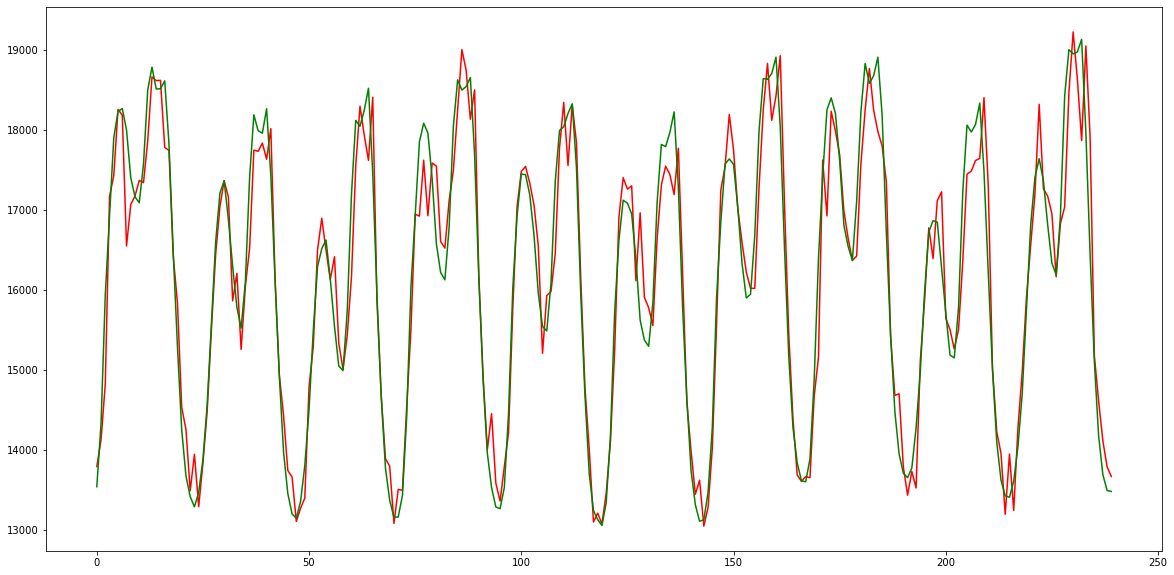

In [29]:
plt.figure(figsize=(20, 10))
load_pred = load_pred.reshape(-1, 24)
load_true = load_true.reshape(-1, 24)
plt.plot(load_pred[:240, 0], 'r')
plt.plot(load_true[:240, 0], 'g')